In [1]:

import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from simulate import SimulationDataset  
import jax
from jax import jit, vmap, grad, random, value_and_grad
import jax.numpy as jnp


### Set device

In [2]:
seed = 0
# random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("Using CPU")



Using MPS (Apple Silicon)


### Define the parameters for the simulation

In [3]:
ns = 10000
sim = 'charge'
n = 4
dim = 2
nt = 1000
dt = 1e-3

### Generate the dataset and see the shape

In [4]:
import simulate
from simulate import SimulationDataset
simulation = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
simulation.simulate(ns)

In [5]:
simulation.data.shape

(10000, 500, 4, 6)

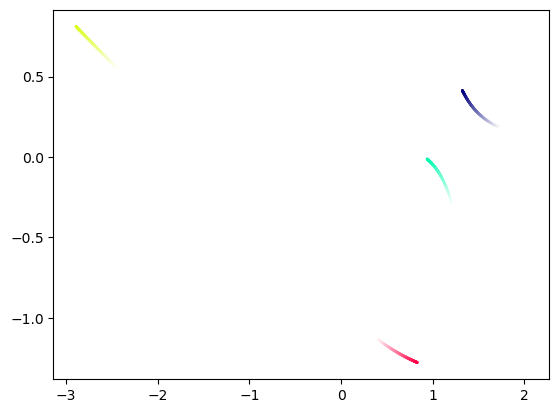

In [6]:
simulation.plot(0, animate=True, plot_size=False)

### Split the data and put into dataloader

In [7]:
accel_data = simulation.get_acceleration()

# Convert simulation and acceleration data directly to tensors
X = torch.tensor(np.array(simulation.data), dtype=torch.float32)  # Shape: (num_samples, num_time_steps, num_particles, num_features)
Y = torch.tensor(np.array(accel_data), dtype=torch.float32)       # Shape: (num_samples, num_time_steps, num_particles, output_dim)

# Select every 5th timestep along time dimension
X = X[:, ::5].reshape(-1, X.shape[2], X.shape[3])  # Flatten sample & time dims
Y = Y[:, ::5].reshape(-1, Y.shape[2], Y.shape[3])  # Flatten sample & time dims

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False)

In [8]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

torch.Size([750000, 4, 6]) torch.Size([250000, 4, 6]) torch.Size([750000, 4, 2]) torch.Size([250000, 4, 2])


In [8]:
from models import NbodyGNN,get_edge_index

edge_index = get_edge_index(n, sim)


from torch_geometric.data import Data, DataLoader

train_data_list = [
    Data(
        x=X_train[i],  
        edge_index=edge_index,  
        y=Y_train[i]
    ) for i in range(len(Y_train))
]

test_indices = np.random.choice(len(X_test), size=1024, replace=False)  # Randomly select 1024 indices from the test set
test_data_list = [
    Data(
        x=X_test[i],  
        edge_index=edge_index,  
        y=Y_test[i]
    ) for i in test_indices
]



batch = 64

trainloader = DataLoader(train_data_list, batch_size=batch, shuffle=True)
testloader = DataLoader(test_data_list, batch_size=1024, shuffle=False)


/Users/liuyihao/Desktop/yl2063/src/models.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e3pikzc5fh/croot/libtorch_1738337599132/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Standard model

In [9]:
aggr = 'add'
hidden = 300
msg_dim = 100
n_f = simulation.data.shape[3]


In [10]:
from torch.optim.lr_scheduler import OneCycleLR
initial_learing_rate = 1e-3


total_epochs = 30


batch_per_epoch = len(trainloader)


batch_per_epoch

11719

In [12]:

model_standard = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_standard = torch.optim.Adam(model_standard.parameters(), lr=initial_learing_rate, weight_decay=1e-8)


sched_standard = OneCycleLR(opt_standard, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [13]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-charge-standard", reinit=True)

for epoch in range(total_epochs):
    model_standard.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_standard.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_standard.loss(batch)
        loss.backward()
        opt_standard.step()
        sched_standard.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 69.932863
Epoch 2/30, Loss: 59.201136
Epoch 3/30, Loss: 56.315911
Epoch 4/30, Loss: 54.412246
Epoch 5/30, Loss: 52.469408
Epoch 6/30, Loss: 50.635447
Epoch 7/30, Loss: 50.001933
Epoch 8/30, Loss: 49.617368
Epoch 9/30, Loss: 48.766967
Epoch 10/30, Loss: 48.011605
Epoch 11/30, Loss: 46.861297
Epoch 12/30, Loss: 45.630391
Epoch 13/30, Loss: 45.206820
Epoch 14/30, Loss: 44.269280
Epoch 15/30, Loss: 43.529187
Epoch 16/30, Loss: 41.223626
Epoch 17/30, Loss: 40.735620
Epoch 18/30, Loss: 39.136068
Epoch 19/30, Loss: 37.577107
Epoch 20/30, Loss: 35.545240
Epoch 21/30, Loss: 34.132192
Epoch 22/30, Loss: 31.769012
Epoch 23/30, Loss: 29.678106
Epoch 24/30, Loss: 26.667627
Epoch 25/30, Loss: 23.552197
Epoch 26/30, Loss: 20.107646
Epoch 27/30, Loss: 17.091129
Epoch 28/30, Loss: 14.577001
Epoch 29/30, Loss: 12.840247
Epoch 30/30, Loss: 12.149349


In [14]:
# Save the model state
import os

root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "charge_standard.pth")

torch.save(model_standard.state_dict(), save_path)

In [11]:
import os
model_standard = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "charge_standard.pth")
state_dict = torch.load(save_path, map_location=device)
model_standard.load_state_dict(state_dict)


model_standard.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_27691/3570540898.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locati

NbodyGNN()

In [15]:
model_standard.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_standard(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 2.618939


Selected channels: ['msg93', 'msg20']


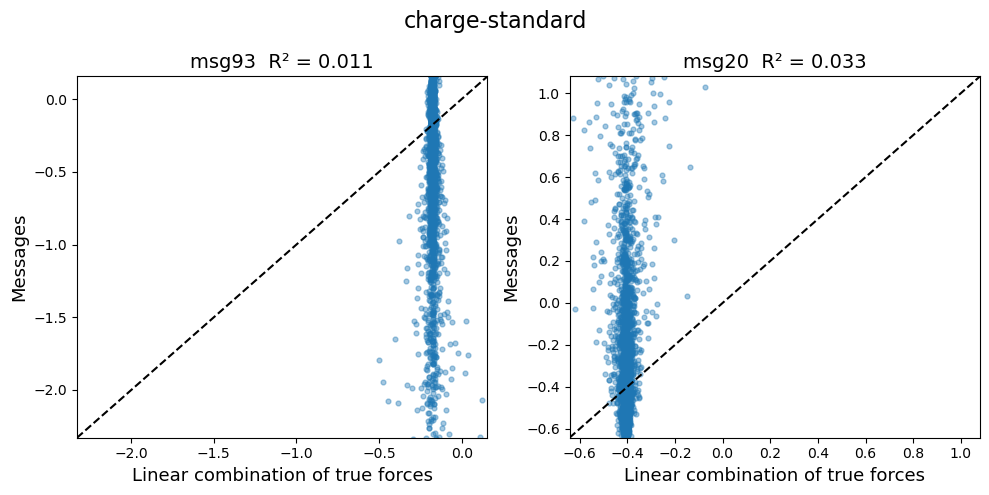

In [12]:

from message_processing import measure_latent, fit_multioutput_force
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Measure latent variables
latent_df_standard = measure_latent(model_standard, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_standard['fx_true'] = (latent_df_standard['q1'] * latent_df_standard['q2']) * \
                    (latent_df_standard['dx'] / (latent_df_standard['r'] ** 3 + 1e-5))
latent_df_standard['fy_true'] = (latent_df_standard['q1'] * latent_df_standard['q2']) * \
                    (latent_df_standard['dy'] / (latent_df_standard['r'] ** 3 + 1e-5))

# Fit multi-output linear regression to find top channels
lr, top_channels= fit_multioutput_force(latent_df_standard, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_standard[['fx_true','fy_true']].values

# True messages
Messages = latent_df_standard[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("charge-standard", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()


In [13]:
import pysr
sr_standard= pysr.PySRRegressor(
  niterations=100,
  binary_operators=["+", "-", "*", "/"],
  unary_operators=["cube"],
  run_id="charge-standard",
  random_state=seed,
  parallelism="serial"
)
df_sub_standard = latent_df_standard[['dx','dy','r','q1','q2', top_channels[0]]].sample(5000, random_state=seed)
X = df_sub_standard[['dx','dy','r','q1','q2']].values
Y = df_sub_standard[top_channels[0]].values
sr_standard.fit(X, Y)
print(sr_standard)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 6.970e+04
Progress: 379 / 3100 total iterations (12.226%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.002e+00  1.594e+01  y = -0.16153
3           5.863e-01  2.679e-01  y = -0.1747 / x₂
5           3.793e-01  2.178e-01  y = -0.47791 / (x₂ + 0.016045)
6           2.519e-01  4.092e-01  y = cube(-0.62749 / (x₂ + 0.23298))
8           2.493e-01  5.087e-03  y = cube(-0.65468 / (x₂ + 0.2451)) + 0.058265
10          2.477e-01  3.211e-03  y = cube((x₄ * 0.028966) + (-0.6043 / (x₂ + 0.22311)))
12          2.410e-01  1.377e-02  y = cube(-0.6043 / ((x₂ + ((x₁ / x₄) * 0.17822)) + 0.22311...
                                      ))
19          2.337e-01  4.417e-03  y = (-0.41628 / (cube(x₂ + 0.26902) + ((x₁ + (x₄ * x₂)) / ...
                            

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 7.470e+04
Progress: 1133 / 3100 total iterations (36.548%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.002e+00  1.594e+01  y = -0.16153
3           5.863e-01  2.679e-01  y = -0.1747 / x₂
5           3.793e-01  2.178e-01  y = -0.47791 / (x₂ + 0.016045)
6           2.519e-01  4.092e-01  y = cube(-0.626 / (x₂ + 0.23254))
8           2.493e-01  5.103e-03  y = cube(-0.65087 / (x₂ + 0.24352)) + 0.057261
10          2.464e-01  5.981e-03  y = cube((-0.5124 / (x₂ + 0.2023)) - 0.19368) + 0.11593
11          2.455e-01  3.647e-03  y = (-0.33607 / ((x₂ - -0.13964) * (x₂ + 0.11498))) + 0.12...
                                      677
12          2.410e-01  1.830e-02  y = cube(-0.6043 / ((x₂ + ((x₁ / x₄) * 0.17822)) + 0.22311...
                          

### Bottleneck model

In [16]:

msg_dim_bottleneck=2

model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_bottleneck = torch.optim.Adam(model_bottleneck.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_bottleneck = OneCycleLR(opt_bottleneck, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)


In [20]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-charge-bottleneck", reinit=True)
for epoch in range(total_epochs):
    model_bottleneck.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_bottleneck.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_bottleneck.loss(batch)
        loss.backward()
        opt_bottleneck.step()
        sched_bottleneck.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▁▁▁
epoch,30
train_loss,12.14935


Epoch 1/30, Loss: 73.620362
Epoch 2/30, Loss: 64.156282
Epoch 3/30, Loss: 60.194363
Epoch 4/30, Loss: 56.316509
Epoch 5/30, Loss: 52.106726
Epoch 6/30, Loss: 50.000518
Epoch 7/30, Loss: 49.105306
Epoch 8/30, Loss: 49.113071
Epoch 9/30, Loss: 48.067616
Epoch 10/30, Loss: 47.052530
Epoch 11/30, Loss: 45.875438
Epoch 12/30, Loss: 45.081127
Epoch 13/30, Loss: 43.771014
Epoch 14/30, Loss: 43.019423
Epoch 15/30, Loss: 42.012654
Epoch 16/30, Loss: 41.020028
Epoch 17/30, Loss: 39.042920
Epoch 18/30, Loss: 39.147252
Epoch 19/30, Loss: 37.461793
Epoch 20/30, Loss: 35.277694
Epoch 21/30, Loss: 33.004220
Epoch 22/30, Loss: 30.920956
Epoch 23/30, Loss: 28.409669
Epoch 24/30, Loss: 26.435866
Epoch 25/30, Loss: 23.180331
Epoch 26/30, Loss: 20.245281
Epoch 27/30, Loss: 17.592828
Epoch 28/30, Loss: 15.405660
Epoch 29/30, Loss: 13.948833
Epoch 30/30, Loss: 13.274377


In [21]:
import os


root_checkpoints = os.path.join("..", "model_weights")

os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "charge_bottleneck.pth")

torch.save(model_bottleneck.state_dict(), save_path)

In [17]:
import os
model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "charge_bottleneck.pth")
state_dict = torch.load(save_path, map_location=device)
model_bottleneck.load_state_dict(state_dict)


model_bottleneck.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_27691/2639548146.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locati

NbodyGNN()

In [22]:
model_bottleneck.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_bottleneck(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 3.265526


Selected channels: ['msg0', 'msg1']


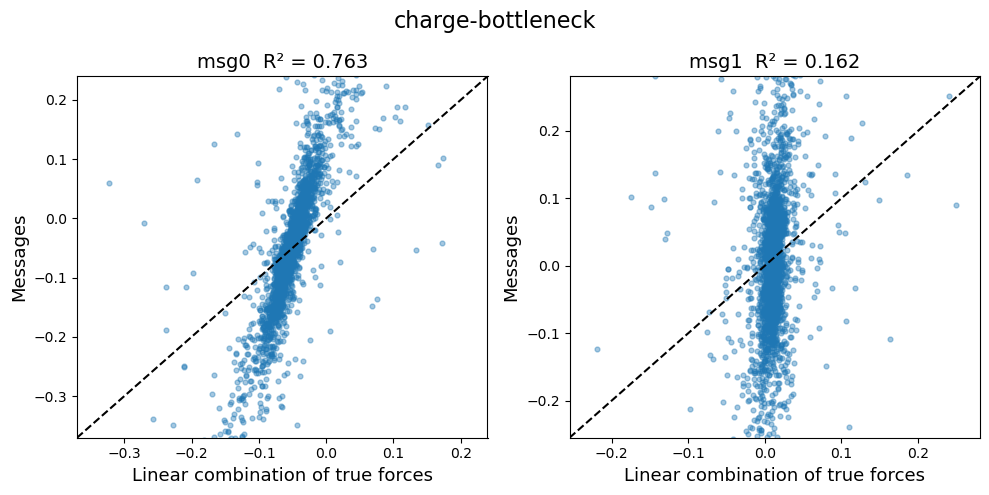

In [18]:
from message_processing import measure_latent, fit_multioutput_force
from sklearn.metrics import r2_score


# Measure latent variables
latent_df_bottleneck = measure_latent(model_bottleneck, testloader, device=device, dim=dim, msg_dim=msg_dim_bottleneck)

# compute true force components and add them to latent_df
latent_df_bottleneck['fx_true'] = (latent_df_bottleneck['q1'] * latent_df_bottleneck['q2']) * \
                    (latent_df_bottleneck['dx'] / (latent_df_bottleneck['r'] ** 3 + 1e-5))
latent_df_bottleneck['fy_true'] = (latent_df_bottleneck['q1'] * latent_df_bottleneck['q2']) * \
                    (latent_df_bottleneck['dy'] / (latent_df_bottleneck['r'] ** 3 + 1e-5))

# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_bottleneck, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_bottleneck[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_bottleneck[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("charge-bottleneck", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()

In [19]:
import pysr
sr_bottleneck = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["cube"],
    run_id="charge-bottleneck",
    random_state=seed,
    parallelism="serial"
)
df_sub_bottleneck = latent_df_bottleneck[['dx', 'dy', 'r', 'q1','q2', top_channels[0]]].sample(5000, random_state=seed)
X = df_sub_bottleneck[['dx', 'dy', 'r','q1','q2']].values
Y = df_sub_bottleneck[top_channels[0]].values
sr_bottleneck.fit(X, Y)
print(sr_bottleneck)



/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.520e+04
Progress: 351 / 3100 total iterations (11.323%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.795e-01  1.594e+01  y = -0.05499
5           1.477e-01  4.872e-02  y = (x₃ / x₂) * -0.049043
6           1.302e-01  1.258e-01  y = -2.3851e-06 * (x₃ / cube(x₂))
7           1.084e-01  1.832e-01  y = ((0.00020372 / x₀) / x₂) - 0.058874
9           1.084e-01  9.866e-05  y = (((-0.014051 / x₀) / x₂) + 3.7412) * -0.014499
11          1.076e-01  3.887e-03  y = -0.021965 * ((((-0.0092384 / x₀) - x₁) / x₂) + 2.1628)
12          1.074e-01  2.114e-03  y = -0.021965 * (((-0.0092384 / (x₀ - cube(x₁))) / x₂) + 2...
                                      .1628)
13          1.059e-01  1.382e-02  y = ((((x₄ / 0.80849) + (-0.014272 / x₀)) / x₂) + 2.9946) ...

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.795e-01  1.594e+01  y = -0.05499
5           1.114e-01  1.193e-01  y = (0.00020372 / x₀) / x₂
7           7.573e-02  1.928e-01  y = (x₁ / x₂) * (0.099478 / x₂)
8           2.545e-02  1.091e+00  y = (x₁ * 0.056727) / cube(x₂ + 0.02464)
10          2.261e-02  5.918e-02  y = ((0.056727 / cube(0.02464 + x₂)) * x₁) - 0.055015
12          1.673e-02  1.506e-01  y = x₁ * cube(-0.40091 / (((0.02621 + x₂) * x₃) * x₄))
14          1.380e-02  9.623e-02  y = ((x₃ * cube(-0.40091 / (x₂ + 0.02621))) * (x₁ * x₄)) +...
                                       -0.054782
16          9.911e-03  1.655e-01  y = (((x₁ * x₃) - (-0.21645 * x₀)) * -0.067811) / (x₄ * cu...
                                      be(x₂ + 0.027106))
17          9.911e-03  -0.000e+00  y = -0.067811 * (((cube(x₃) * x₁) - (-0.21645 * x₀)) / (x...
                                     

### L1 regularization model

In [37]:
model_l1 = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0.02).to(device)

opt_l1 = torch.optim.Adam(model_l1.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_l1 = OneCycleLR(opt_l1, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [38]:
wandb.init(project="DIS-final-pro", name="Train-charge-l1", reinit=True)
for epoch in range(total_epochs):
    model_l1.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_l1.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_l1.loss(batch)
        loss.backward()
        opt_l1.step()
        sched_l1.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁
epoch,30
train_loss,13.27438


Epoch 1/30, Loss: 78.911045
Epoch 2/30, Loss: 71.406256
Epoch 3/30, Loss: 58.799587
Epoch 4/30, Loss: 56.570858
Epoch 5/30, Loss: 53.727773
Epoch 6/30, Loss: 52.075074
Epoch 7/30, Loss: 51.199578
Epoch 8/30, Loss: 50.280004
Epoch 9/30, Loss: 49.029515
Epoch 10/30, Loss: 48.417935
Epoch 11/30, Loss: 48.197031
Epoch 12/30, Loss: 46.845042
Epoch 13/30, Loss: 46.142125
Epoch 14/30, Loss: 45.080202
Epoch 15/30, Loss: 43.873759
Epoch 16/30, Loss: 42.374016
Epoch 17/30, Loss: 41.330792
Epoch 18/30, Loss: 39.912209
Epoch 19/30, Loss: 38.547332
Epoch 20/30, Loss: 37.198608
Epoch 21/30, Loss: 35.246986
Epoch 22/30, Loss: 33.807399
Epoch 23/30, Loss: 30.953126
Epoch 24/30, Loss: 28.515570
Epoch 25/30, Loss: 24.642779
Epoch 26/30, Loss: 21.312923
Epoch 27/30, Loss: 18.045756
Epoch 28/30, Loss: 15.024632
Epoch 29/30, Loss: 12.858521
Epoch 30/30, Loss: 11.953384


In [39]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "charge_l1.pth")

torch.save(model_l1.state_dict(), save_path)

In [20]:
import os
model_l1 = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0.02).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "charge_l1.pth")
state_dict = torch.load(save_path, map_location=device)
model_l1.load_state_dict(state_dict)


model_l1.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_27691/2771916711.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locati

NbodyGNN()

In [40]:
model_l1.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_l1(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.403052


Selected channels: ['msg34', 'msg94']


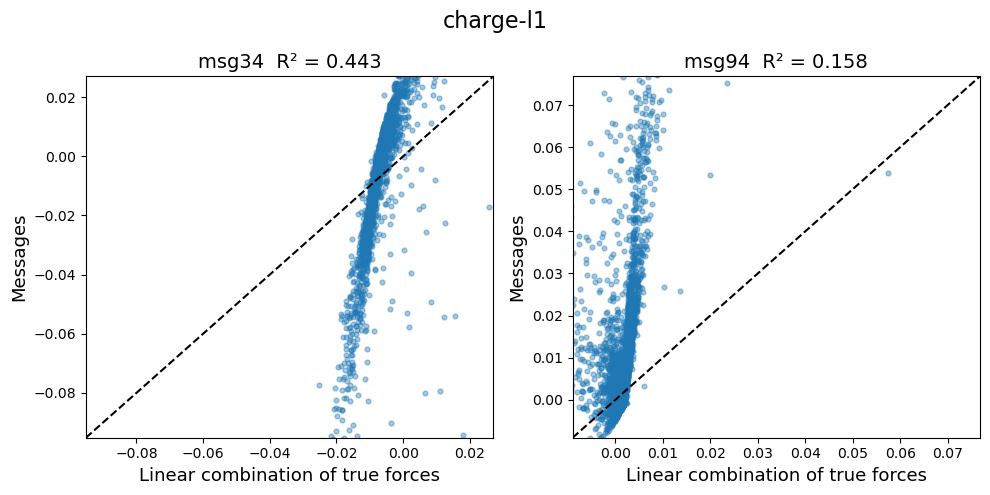

In [22]:
# Measure latent variables
latent_df_l1 = measure_latent(model_l1, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_l1['fx_true'] = (latent_df_l1['q1'] * latent_df_l1['q2']) * \
                    (latent_df_l1['dx'] / (latent_df_l1['r'] ** 3 + 1e-5))
latent_df_l1['fy_true'] = (latent_df_l1['q1'] * latent_df_l1['q2']) * \
                    (latent_df_l1['dy'] / (latent_df_l1['r'] ** 3 + 1e-5))


# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_l1, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_l1[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_l1[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("charge-l1", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()

In [23]:
import pysr
sr_l1 = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["cube"],
    run_id="charge-l1",
    random_state=seed,
    parallelism="serial"
)
df_sub_l1 = latent_df_l1[['dx', 'dy', 'r', 'q1','q2',top_channels[0]]].sample(5000,random_state=seed)
X = df_sub_l1[['dx', 'dy', 'r','q1','q2']].values
Y = df_sub_l1[top_channels[0]].values
sr_l1.fit(X, Y)
print(sr_l1)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.860e+04
Progress: 398 / 3100 total iterations (12.839%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.876e-03  1.594e+01  y = -0.0067946
3           3.498e-03  1.661e-01  y = -0.0099211 / x₂
5           3.166e-03  4.979e-02  y = -0.020935 / (x₂ - -0.0096053)
6           2.701e-03  1.589e-01  y = -0.0045174 / cube(x₂ - -0.146)
8           2.701e-03  6.533e-05  y = 0.0070526 / (cube(-0.14439 - x₂) * 1.5885)
10          2.635e-03  1.231e-02  y = -0.0045174 / (cube(x₂ - -0.146) / (x₀ + 0.96227))
11          1.607e-03  4.945e-01  y = 0.35981 / cube(cube(((-0.83288 - x₂) - x₂) - x₁))
15          1.375e-03  3.890e-02  y = cube(0.43532 / cube(((-0.63883 - x₂) - x₂) - (x₁ * 1.3...
                                      621))) / 2.2791
18          1.24

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.876e-03  1.594e+01  y = -0.0067946
3           3.498e-03  1.661e-01  y = -0.0099211 / x₂
5           3.166e-03  4.980e-02  y = -0.021165 / (x₂ - -0.0096772)
6           2.701e-03  1.590e-01  y = -0.004401 / cube(x₂ - -0.14379)
9           2.140e-03  7.760e-02  y = -0.015532 / ((x₂ - (x₁ * -0.75943)) + 0.0054774)
10          1.370e-03  4.457e-01  y = -0.00049831 / cube((x₂ - (-0.75772 * x₁)) - -0.060581)
13          1.061e-03  8.535e-02  y = 0.14182 / cube(cube(-0.84707 - (x₂ - (x₁ / (x₂ / -0.12...
                                      777)))))
15          8.526e-04  1.092e-01  y = cube(0.26063 / cube(-0.64832 - (x₂ - (x₁ / ((x₂ / -0.1...
                                      1625) - 0.068957)))))
17          8.477e-04  2.917e-03  y = cube(0.26861 / cube(-0.65549 - ((x₂ - (x₁ / ((x₂ / -0....
                                      118

### KL divergence model

In [25]:
from models import VariationNbody

In [44]:
model_kl = VariationNbody(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), beta=1.0).to(device)

opt_kl = torch.optim.Adam(model_kl.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_kl = OneCycleLR(opt_kl, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [45]:
import wandb
wandb.init(project="DIS-final-pro-kl", name="Train-charge", reinit=True)
for epoch in range(total_epochs):
    model_kl.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_kl.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_kl.loss(batch)
        loss.backward()
        opt_kl.step()
        sched_kl.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁
epoch,30
train_loss,11.95338


Epoch 1/30, Loss: 9.870346
Epoch 2/30, Loss: 9.848920
Epoch 3/30, Loss: 9.830785
Epoch 4/30, Loss: 9.797176
Epoch 5/30, Loss: 9.772761
Epoch 6/30, Loss: 9.702490
Epoch 7/30, Loss: 9.207432
Epoch 8/30, Loss: 8.997829
Epoch 9/30, Loss: 8.830855
Epoch 10/30, Loss: 8.709789
Epoch 11/30, Loss: 8.535051
Epoch 12/30, Loss: 8.475780
Epoch 13/30, Loss: 8.394149
Epoch 14/30, Loss: 8.281237
Epoch 15/30, Loss: 8.250024
Epoch 16/30, Loss: 8.010461
Epoch 17/30, Loss: 7.875370
Epoch 18/30, Loss: 7.742325
Epoch 19/30, Loss: 7.528217
Epoch 20/30, Loss: 7.395244
Epoch 21/30, Loss: 7.199378
Epoch 22/30, Loss: 7.051848
Epoch 23/30, Loss: 6.748611
Epoch 24/30, Loss: 6.412494
Epoch 25/30, Loss: 6.151852
Epoch 26/30, Loss: 5.830792
Epoch 27/30, Loss: 5.468600
Epoch 28/30, Loss: 5.205524
Epoch 29/30, Loss: 5.006489
Epoch 30/30, Loss: 4.918682


In [46]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "charge_kl.pth")

torch.save(model_kl.state_dict(), save_path)

In [26]:
import os
model_kl = VariationNbody(n_f, msg_dim, dim,  hidden=hidden, edge_index=get_edge_index(n, sim), beta=1).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "charge_kl.pth")
state_dict = torch.load(save_path, map_location=device)
model_kl.load_state_dict(state_dict)


model_kl.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_27691/3979877331.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locati

VariationNbody()

In [47]:
model_kl.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_kl(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 2.860381


Top μ channels: ['mu77', 'mu31']
Multi-output μ‐linear fit R² = 0.4668


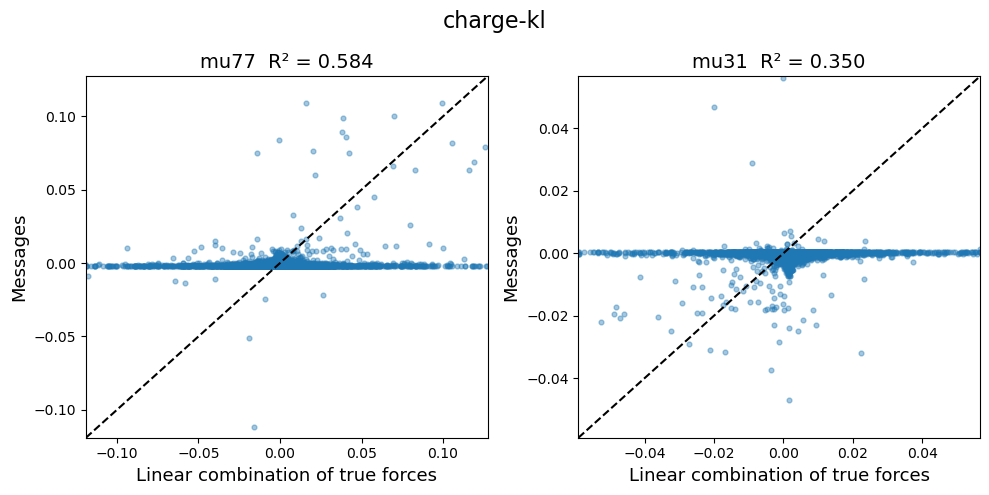

In [27]:
from message_processing import measure_variational_latent
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score   
df = measure_variational_latent(
    model_kl, testloader, device=device,
    dim=dim, msg_dim=msg_dim
)

# Select dim dimensions with largest variance
mu_cols = [c for c in df.columns if c.startswith("mu")]
top_mu  = df[mu_cols].std().nlargest(dim).index.tolist()
print("Top μ channels:", top_mu)

# compute true force components and add them to df
df['fx_true'] = (df['q1'] * df['q2']) * (df['dx'] / (df['r'] ** 3 + 1e-5))
df['fy_true'] = (df['q1'] * df['q2']) * (df['dy'] / (df['r'] ** 3 + 1e-5))


Xs = df[['fx_true','fy_true']].values       # (N,2)
Ysm   = df[top_mu].values                     # (N,dim)

# fit 
lr_mu = LinearRegression().fit(Xs, Ysm)
r2_mu = lr_mu.score(Xs, Ysm)
print(f"Multi-output μ‐linear fit R² = {r2_mu:.4f}")
# Predicted message value using the linear regression model from the force
Predicted_messages = lr_mu.predict(Xs)

fig, axes = plt.subplots(1, dim, figsize=(10, 5))
fig.suptitle("charge-kl", fontsize=16)

for idx, ch in enumerate(top_mu):
    y_true_ch = Ysm[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()

In [28]:

import pysr
sr_kl = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/" ],
    unary_operators=["cube"],
    run_id="charge-kl",
    random_state=seed,
    parallelism="serial"
)
df_sub_kl = df[['dx', 'dy', 'r', 'q1','q2',top_mu[0]]].sample(5000,random_state=seed)
X = df_sub_kl[['dx', 'dy', 'r','q1','q2']].values
Y = df_sub_kl[top_mu[0]].values
sr_kl.fit(X, Y)
print(sr_kl)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.130e+04
Progress: 370 / 3100 total iterations (11.935%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.080e-01  1.594e+01  y = 0.0028739
3           2.078e-01  6.085e-04  y = 0.0001881 / x₁
5           2.071e-01  1.713e-03  y = (x₀ * -0.04428) / x₂
7           1.800e-01  6.996e-02  y = (x₀ * -0.083674) / (x₂ + -0.058048)
8           1.403e-01  2.495e-01  y = (x₀ / cube(x₂ + 0.039458)) * -0.081479
10          8.250e-02  2.654e-01  y = -0.070253 * ((x₀ - x₁) / cube(x₂ + 0.038953))
12          8.170e-02  4.852e-03  y = ((x₁ * -0.88681) + x₀) * cube(-0.43029 / (x₂ + 0.03996...
                                      ))
13          8.139e-02  3.880e-03  y = cube(((x₀ + (x₁ * -0.94672)) / cube(x₂ + 0.082042)) * ...
                                   

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                       0.0028739406   
	1         0.000609                                 0.00018809842 / x1   
	2         0.098663                 0.0122103505 / (x2 + -0.054956984)   
	3         0.072684           0.023943864 / (x2 + (-0.054956984 / x4))   
	4         0.050210       (x0 * -0.080822274) / cube(x2 + 0.039009087)   
	5         0.086849       cube(-0.1469405 / cube(x2 + 0.2536527)) * x0   
	6   >>>>  0.453539  ((x0 - x1) / cube(x2 + 0.034672305)) * -0.0649...   
	7         0.081638  cube(-0.18584488 / cube(x2 + 0.28687924)) * (x...   
	8         0.001413  (x0 - (x1 * 0.9247568)) * cube(-0.18303551 / c...   
	9         0.032687  (-0.10053015 / cube((x2 + 0.04601627) - cube(x...   
	10        0.016854  ((x0 - x1) * -0.08182793) / (((x3 + x4) / 0.00...   
	11        0.024870  (x0 - x1) * (-0.10118468 / cube((0.04601627 + ...   
	12      

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 4095: unexpected end of data